# Parallel Node Execution

In [1]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

### Fan in and Fan out

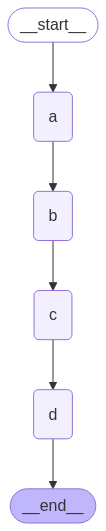

In [2]:
from IPython.display import Image , display

import operator
from typing import Annotated , Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph , START , END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self , node_secret: str):
        self._value = node_secret

    def __call__(self , state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}
    

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a" , ReturnNodeValue("I'm A"))
builder.add_node("b" , ReturnNodeValue("I'm B"))
builder.add_node("c" , ReturnNodeValue("I'm C"))
builder.add_node("d" , ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START , "a")
builder.add_edge("a" , "b")
builder.add_edge("b" , "c")
builder.add_edge("c" , "d")
builder.add_edge("d" , END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"state":[]})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

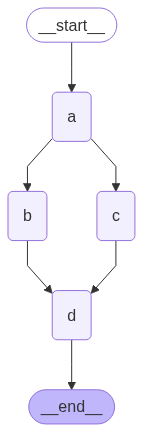

In [4]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


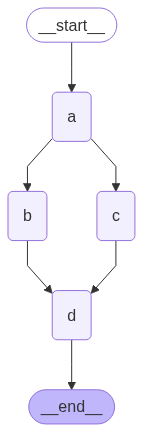

In [6]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

### Waiting for nodes to finish

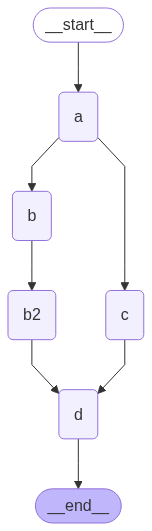

In [8]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"state":[]})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

### Setting the order of state updates

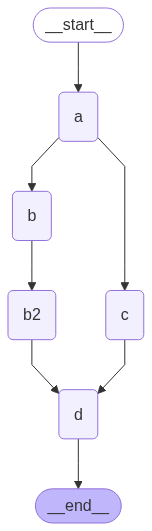

In [10]:
def sorting_reducer(left , right):
    """Combines and sorts the values in a list"""
    if not isinstance(left , list):
        left = [left]
    
    if not isinstance(right , list):
        right = [right]
    
    return sorted(left + right , reverse=False)


class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list , sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"state":[]})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

### Working with LLMs

In [12]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [13]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = os.getenv("GROQ_MODEL_NAME") , temperature=0)

In [14]:
class State(TypedDict):
    # Append from sources
    question: str
    answer: str
    context: Annotated[list , operator.add]

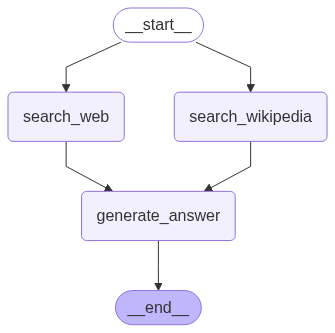

In [15]:
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage , SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state):

    """Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_result = 3)
    search_docs = tavily_search.invoke(state["question"])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query = state["question"] , load_max_docs = 2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question = question , context = context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web" , search_web)
builder.add_node("search_wikipedia" , search_wikipedia)
builder.add_node("generate_answer" , generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were strong, with record revenue of $30.0 billion, up 15% from the previous quarter and up 122% from a year ago. GAAP earnings per diluted share were $0.67, up 12% from the previous quarter and up 168% from a year ago, while non-GAAP earnings per diluted share were $0.68, up 11% from the previous quarter and up 152% from a year ago. The company's data center division performed particularly well, with revenue of $26.3 billion, up 16% sequentially and up 150% year over year. Nvidia also returned $15.4 billion to shareholders in the form of share repurchases and cash dividends during the first half of fiscal 2025."

In [1]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [2]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    answer = event.data.get('answer', None)
    if answer:
        print(answer['content'])

Nvidia's Q2 2024 earnings were strong, with revenue of $30.0 billion, up 15% from the previous quarter and up 122% from a year ago. GAAP earnings per diluted share were $0.67, up 12% from the previous quarter and up 168% from a year ago. Non-GAAP earnings per diluted share were $0.68, up 11% from the previous quarter and up 152% from a year ago. The company also returned $15.4 billion to shareholders in the form of shares repurchased and cash dividends during the first half of fiscal 2025.
